<a href="https://colab.research.google.com/github/MatiasSiles/MastercardSalesOptimization/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project only search predict the Mastercard Sales using a dataset more appropriate. I don't Data Wrangling because it is innecesary in this case and i want to focus in the most important

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.graph_objects import Candlestick, Figure

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [47]:
# Configuration
df = pd.read_csv("/content/Mastercard Dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.loc[df.Date.dt.year >= 2018]
sales = df[["Date", "Close"]].set_index(df["Date"]).drop("Date", axis=1)

In [76]:
class Forecasting_Mastercard():
  def __init__(self, *, data, data_sales):
    self.data = data
    self.data_sales = data_sales

  class eda():
    def __init__(self):
      df = Forecasting_Mastercard.data
      sales = Forecasting_Mastercard.data_sales

    def stadistical_summary():
      return df.select_dtypes(exclude="datetime").describe().round(2)

    def plot_stock():
      df_plot_stock = df.drop(columns={"Adj Close","Volume"}, axis=1).set_index(df["Date"]).drop("Date", axis=1)

      Figure(data=[
          Candlestick(
              x=df_plot_stock.index, open=df_plot_stock["Open"], high=df_plot_stock["High"],
              low=df_plot_stock["Low"], close=df_plot_stock["Close"])
          ]).show()

    def high_low_volatility():
      df_high_low = df[["Date", "High", "Low"]].set_index(df["Date"]).drop("Date", axis=1)
      df_high_low = df_high_low["High"] - df_high_low["Low"]

      df_high_low.plot(figsize=(15,5))
      plt.show()

    def daily_returns():
      daily_returns = sales.Close.pct_change().dropna()

      fig, axes = plt.subplots(1, 2, figsize=(15,5))
      axes[0].hist(daily_returns)
      axes[1].boxplot(daily_returns)
      fig.suptitle("Relative Performance")
      plt.show()

    def volume_analysis():
      volume_hist = df[["Date","Volume"]].set_index(df["Date"]).drop("Date", axis=1)
      volume_vs_close = df[["Date","Close","Volume"]].set_index(df["Date"]).drop("Date", axis=1)

      fig, axes = plt.subplots(1, 2, figsize=(15,5))
      axes[0].scatter(volume_vs_close["Close"], volume_vs_close["Volume"])
      axes[0].set_xlabel("Close")
      axes[0].set_ylabel("Volume(relative)")

      axes[1].hist(volume_hist) # Millions to relative numbers, e.g: 3 Millions = 0.3
      axes[1].set_xlabel("Volume(relative)")
      axes[1].set_ylabel("Frequency")
      plt.show()

    def movil_trend(*, window):
      sma = sales.rolling(window=window).mean().dropna() # sma = simple movil average

      sma.plot(figsize=(15,5))
      plt.show()

  class models():
    def __init__(self, data):
      df = Forecasting_Mastercard.data
      sales = Forecasting_Mastercard.data_sales

    def forecasting(*, end_date, seasonal_periods, seasonal, trend):
      model = ExponentialSmoothing(sales["Close"], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
      sales["forecast"] = model.fittedvalues

      # Métricas
      print("Metrics:")
      print(f"MSE: {mean_squared_error(sales['Close'], sales['forecast']):.2f}")
      print(f"MAE: {mean_absolute_error(sales['Close'], sales['forecast']):.2f}")

      # Forecast futuro
      start_date_future = sales.index[-1] + pd.DateOffset(days=1)
      future_dates = pd.date_range(start=start_date_future, end=end_date, freq='D')
      forecast_future = list(model.forecast(len(future_dates)))
      confident_interval = 1.96 * np.std(forecast_future)  # simple intervalo ±1.96σ

      df_future = pd.DataFrame({
          "forecast": forecast_future,
          "lower": forecast_future - confident_interval,
          "upper": forecast_future + confident_interval
      }, index=future_dates)

      df_all = pd.concat([sales, df_future], axis=1)

      # Plot
      plt.figure(figsize=(10,5))
      plt.plot(df_all.index, df_all["Close"], label="Real", color="royalblue", linewidth=2.5)
      plt.plot(df_all.index, df_all["forecast"], label="Predicción", color="orange", alpha=0.8)
      plt.fill_between(df_future.index, df_future["lower"], df_future["upper"], color='orange', alpha=0.2, label="Confianza 95%")

      plt.title("Forecasting de Ventas Mastercard")
      plt.legend()
      plt.tight_layout()
      plt.show()
    # def forecasting(*, end_date, seasonal_periods, trend, seasonal):
    #   model = ExponentialSmoothing(sales["Close"], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()

    #   sales["forecast"] = model.fittedvalues.values.tolist() # save the forecast of current sales

    #   start_date_future_sales = sales.index[-1] + pd.DateOffset(days=1)
    #   start_date_future_sales = start_date_future_sales.strftime("%Y-%m-%d")

    #   dates_future_sales = pd.date_range(start=start_date_future_sales, end=end_date, freq='D')
    #   predict_future_sales = model.forecast(len(dates_future_sales))
    #   data_future_sales = pd.DataFrame({"Close": np.nan, "forecast":list(predict_future_sales)}, index=dates_future_sales)

    #   df_forecast = pd.concat([sales, data_future_sales])
    #   df_forecast["Close"].plot(figsize=(20,5), color='cyan', linewidth=2.7)
    #   df_forecast["forecast"].plot(figsize=(20,5), color='orange', alpha=0.6)

    #   plt.legend()

    #   print("Metrics:")
    #   print(f"MSE: {mean_squared_error(sales['Close'], sales['forecast'])}")
    #   print(f"MAE: {mean_absolute_error(sales['Close'], sales['forecast'])}")

    def detection_anomalies_sales(*, sales, contamination): # detect piks, dips and anomalies
      X = sales # because this model need a 2 dimensional container, not a serie, this is a serie but "[[]]" convert a df

      model = IsolationForest(contamination=contamination, random_state=42) # 5% data will be anomaly
      results = model.fit_predict(X)

      sales["anomalies"] = results
      anomalies = sales[sales["anomalies"] == -1]

      plt.figure(figsize=(15,5))
      sales["Close"].plot()
      plt.scatter(anomalies.index, anomalies["Close"], color='red', label="Anomalies")

      plt.legend()

Forecasting_Mastercard = Forecasting_Mastercard(data=df, data_sales=sales)

Metrics:
MSE: 26.74
MAE: 3.61


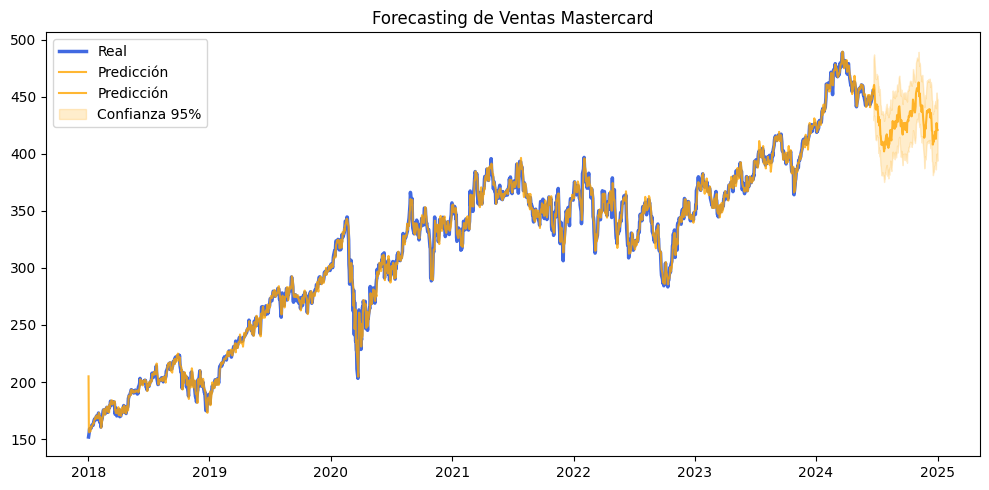

In [79]:
Forecasting_Mastercard.models.forecasting(end_date="2025-01-01", seasonal_periods=365, seasonal="mul", trend="add")

In [75]:
Forecasting_Mastercard.eda.plot_stock()